In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [3]:
# Connect to database sqlite where is stored the information regarding the Dribbble dataset.
conn = sqlite3.connect("dribbble_temporary.db", detect_types = sqlite3.PARSE_DECLTYPES)
c = conn.cursor()

# Dribbble database (data cleaning)

This notebook deals with fixing some inconsistencies in the Dribbble database. In particular, we notice how comparing the time distributions of some tables it is possible to run into some anomalies. 

For example, we find that some comments has been published before the publication of the corresponding shots!

Let's find and fix them.

In [5]:
# Read 'users' table.
users = pd.read_sql("SELECT id, created_at FROM users", conn)

In [4]:
# Read 'likes' table.
likes = pd.read_sql("SELECT shot_id, like_id, created_at, id_author_like FROM likes", conn)

In [6]:
# Read 'followers' table.
followers = pd.read_sql("SELECT id_destination, id_source, created_at FROM followers", conn)

In [7]:
# Read 'comments' table.
comments = pd.read_sql("SELECT shot_id, comment_id, created_at, id_author_comment FROM comments", conn)

In [8]:
# Read 'shots' table.
shots = pd.read_sql("SELECT shot_id, created_at, updated_at, id_author_shot, id_team_username, team_created_at FROM shots", conn)

## Shots -- Comments

### creation shot - creation comment

Compute the time offset between the publication of the shots and the publication of the corresponding comments received.

We expect to have always the comments published after the creation of the corresponding shot publication.

In [9]:
# Compute the time offset between the pubblication of the shots and the pubblication of the corresponding comments received.
shot_comment = pd.merge(comments[["shot_id", "created_at", "comment_id"]], shots[["shot_id", "created_at"]], 
                        on = "shot_id", suffixes = ("_comment", "_shot"), how = "left")

shot_comment["timediff"] = shot_comment.created_at_comment - shot_comment.created_at_shot

In [10]:
# Anomalies.
anomalies_shot_comment = shot_comment[shot_comment.timediff < pd.Timedelta(0)]
# Get the number of hours of our timedelta.
anomalies_shot_comment["timediff_hours"] = anomalies_shot_comment["timediff"] / pd.Timedelta("1 hour")
anomalies_shot_comment.sort_values(by = "timediff_hours", inplace = True)
anomalies_shot_comment

,shot_id,created_at_comment,comment_id,created_at_shot,timediff,timediff_hours
3573921,1636541,2014-07-10 10:18:25,3802643,2014-07-10 12:18:21,-1 days +22:00:04,-1.998889
2256140,1638658,2014-07-11 14:16:44,3806879,2014-07-11 16:16:40,-1 days +22:00:04,-1.998889
564040,1636540,2014-07-10 10:18:11,3802640,2014-07-10 12:18:07,-1 days +22:00:04,-1.998889
1940480,1636539,2014-07-10 10:17:52,3802638,2014-07-10 12:17:48,-1 days +22:00:04,-1.998889
3963377,1638649,2014-07-11 14:14:17,3806864,2014-07-11 16:14:12,-1 days +22:00:05,-1.998611
...,...,...,...,...,...,...
3257395,3895226,2017-10-24 09:58:02,6652550,2017-10-24 09:58:03,-1 days +23:59:59,-0.000278
791957,2614304,2016-03-27 00:11:47,5140683,2016-03-27 00:11:48,-1 days +23:59:59,-0.000278
2538797,2700886,2016-05-09 13:00:13,5253716,2016-05-09 13:00:14,-1 days +23:59:59,-0.000278
262472,3777546,2017-09-01 13:13:58,6517836,2017-09-01 13:13:59,-1 days +23:59:59,-0.000278


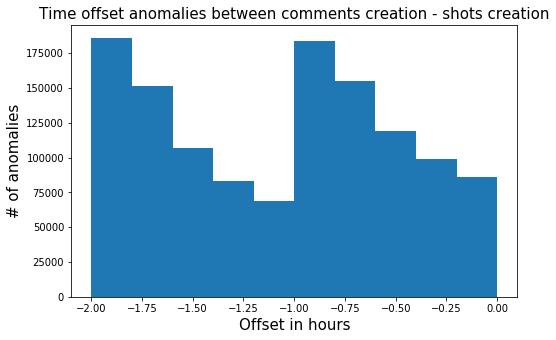

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(anomalies_shot_comment.timediff_hours)
ax.set_title("Time offset anomalies between comments creation - shots creation", fontsize = 15)
ax.set_xlabel("Offset in hours", fontsize = 15)
ax.set_ylabel("# of anomalies", fontsize = 15);

#### Solution

We decide to set as new creation date (*created_at*) of these anomalous shots in the 'shots' table, the date corresponding to the relative oldest comment (-1 minute).

In [12]:
# New data creation.
fix_anomalies = anomalies_shot_comment.groupby("shot_id", as_index = False)["created_at_comment"].min()
fix_anomalies.created_at_comment = fix_anomalies.created_at_comment - pd.Timedelta("1 minute")
fix_anomalies.rename({"created_at_comment": "created_at_shot"}, axis = 1, inplace = True)
fix_anomalies.head()

,shot_id,created_at_shot
0,28,2009-07-31 08:32:39
1,31,2009-07-31 13:39:21
2,38,2009-08-04 08:38:40
3,39,2009-08-04 09:44:09
4,42,2009-08-04 13:10:16


In [14]:
# Save the dataframe into the sql database.
fix_anomalies.to_sql("anomalies_shot_comment", conn, index = False, dtype = {"shot_id": "INT", "created_at_shot": "TIMESTAMP"})

# Fix anomalies.
c.execute("""CREATE UNIQUE INDEX idx_anomalies_shot_comment ON anomalies_shot_comment (shot_id)""")
c.execute("""UPDATE shots SET (created_at) = (SELECT anomalies_shot_comment.created_at_shot FROM anomalies_shot_comment WHERE anomalies_shot_comment.shot_id = shots.shot_id)
                WHERE EXISTS (SELECT * FROM anomalies_shot_comment WHERE anomalies_shot_comment.shot_id = shots.shot_id)""")

c.execute("""DROP TABLE anomalies_shot_comment""")

conn.commit()

In [15]:
# Reload 'shots' table.
shots = pd.read_sql("SELECT shot_id, created_at, updated_at, id_author_shot, id_team_username, team_created_at FROM shots", conn)

## Shots -- Likes

### creation shot - creation like

Compute the time offset between the publications of the shots and the creation of the corresponding likes.

We expect to have always the creation of the likes after the creation of the corresponding shot.

In [16]:
# Compute the time offset between pubblication of the shots and the creation of the corresponding likes.
shot_like = pd.merge(likes[["shot_id", "created_at", "like_id"]], shots[["shot_id", "created_at"]], 
                     on = "shot_id", suffixes = ("_like", "_shot"), how = "left")

shot_like["timediff"] = shot_like.created_at_like - shot_like.created_at_shot

In [18]:
# Anomalies.
anomalies_shot_like = shot_like[shot_like.timediff < pd.Timedelta(0)]
# Get the number of hours of our timedelta.
anomalies_shot_like["timediff_hours"] = anomalies_shot_like["timediff"] / pd.Timedelta("1 hour")
anomalies_shot_like.sort_values(by = "timediff_hours", inplace = True)
anomalies_shot_like

,shot_id,created_at_like,like_id,created_at_shot,timediff,timediff_hours
35461937,2194747,2015-08-13 20:22:15,42675329,2015-08-13 22:22:13,-1 days +22:00:02,-1.999444
12495795,3870655,2017-10-12 17:36:18,98699622,2017-10-12 19:36:16,-1 days +22:00:02,-1.999444
45111809,3554940,2017-06-09 05:57:42,87406107,2017-06-09 07:57:39,-1 days +22:00:03,-1.999167
12080773,3777949,2017-09-01 13:36:56,95086323,2017-09-01 15:36:53,-1 days +22:00:03,-1.999167
11245939,3550043,2017-06-07 09:50:04,87210154,2017-06-07 11:50:01,-1 days +22:00:03,-1.999167
...,...,...,...,...,...,...
79498875,1901035,2015-01-27 08:21:45,35410991,2015-01-27 08:21:46,-1 days +23:59:59,-0.000278
25054529,3188268,2017-01-02 11:13:02,74823414,2017-01-02 11:13:03,-1 days +23:59:59,-0.000278
22140089,3394160,2017-03-28 07:52:49,81840958,2017-03-28 07:52:50,-1 days +23:59:59,-0.000278
46358528,51111,2010-09-01 10:26:31,239213,2010-09-01 10:26:32,-1 days +23:59:59,-0.000278


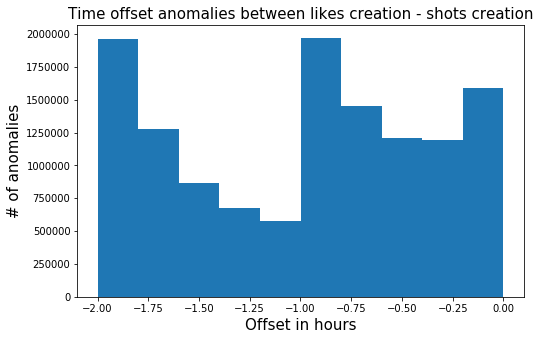

In [19]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(anomalies_shot_like.timediff_hours)
ax.set_title("Time offset anomalies between likes creation - shots creation", fontsize = 15)
ax.set_xlabel("Offset in hours", fontsize = 15)
ax.set_ylabel("# of anomalies", fontsize = 15);

#### Solution

We decide to set as new creation date (*created_at*) of these anomalous shots in the 'shots' table, the date corresponding to the relative oldest like (-1 minute).

In [20]:
# New data creation.
fix_anomalies = anomalies_shot_like.groupby("shot_id", as_index = False)["created_at_like"].min()
fix_anomalies.created_at_like = fix_anomalies.created_at_like - pd.Timedelta("1 minute")
fix_anomalies.rename({"created_at_like": "created_at_shot"}, axis = 1, inplace = True)
fix_anomalies.head()

,shot_id,created_at_shot
0,30,2009-07-31 13:30:35
1,40,2009-08-04 10:46:10
2,41,2009-08-04 10:45:05
3,58,2009-08-07 08:22:42
4,61,2009-08-07 09:10:50


In [21]:
# Save the dataframe into the sql database.
fix_anomalies.to_sql("anomalies_shot_like", conn, index = False, dtype = {"shot_id": "INT", "created_at_shot": "TIMESTAMP"})

# Fix anomalies.
c.execute("""CREATE UNIQUE INDEX idx_anomalies_shot_like ON anomalies_shot_like (shot_id)""")
c.execute("""UPDATE shots SET (created_at) = (SELECT anomalies_shot_like.created_at_shot FROM anomalies_shot_like WHERE anomalies_shot_like.shot_id = shots.shot_id)
                WHERE EXISTS (SELECT * FROM anomalies_shot_like WHERE anomalies_shot_like.shot_id = shots.shot_id)""")

c.execute("""DROP TABLE anomalies_shot_like""")

conn.commit()

In [22]:
# Reload 'shots' table.
shots = pd.read_sql("SELECT shot_id, created_at, updated_at, id_author_shot, id_team_username, team_created_at FROM shots", conn)

# Users -- Shots

### creation author - creation shot

Compute the time offset between the pubblication of the shots and the creation of the corresponding authors.

We expect to have always the shots after the creation of the corresponding author.

In [23]:
# Compute the time offset between the pubblication of the shots and the creation of the corresponding authors.
user_shot = pd.merge(shots[["id_author_shot", "created_at", "shot_id"]], users[["id", "created_at"]], left_on = "id_author_shot", right_on = "id", 
                     suffixes = ("_shot", "_author"), how = "left").drop("id", axis = 1)

user_shot["timediff"] = user_shot.created_at_shot - user_shot.created_at_author

In [24]:
# Anomalies.
anomalies_user_shot = user_shot[user_shot.timediff < pd.Timedelta(0)]
# Get the number of hours of our timedelta.
anomalies_user_shot["timediff_hours"] = anomalies_user_shot["timediff"] / pd.Timedelta("1 hour")
anomalies_user_shot.sort_values(by = "timediff_hours", inplace = True)
anomalies_user_shot

,id_author_shot,created_at_shot,shot_id,created_at_author,timediff,timediff_hours
2241172,1442706,2016-10-29 06:53:23,3057038,2016-10-29 08:52:38,-1 days +22:00:45,-1.987500
2252387,388917,2013-08-20 00:04:14,1202606,2013-08-20 02:03:20,-1 days +22:00:54,-1.985000
2467040,1805849,2017-07-05 15:57:51,3631674,2017-07-05 17:56:42,-1 days +22:01:09,-1.980833
411895,32721,2011-05-05 09:35:25,162824,2011-05-05 11:33:30,-1 days +22:01:55,-1.968056
1710939,56298,2011-08-23 04:38:12,243604,2011-08-23 06:36:12,-1 days +22:02:00,-1.966667
...,...,...,...,...,...,...
1882242,1197283,2016-06-01 02:13:14,2749183,2016-06-01 02:13:18,-1 days +23:59:56,-0.001111
575371,1136,2010-03-18 14:57:31,9173,2010-03-18 14:57:34,-1 days +23:59:57,-0.000833
2006236,6182,2010-12-24 20:09:34,93350,2010-12-24 20:09:37,-1 days +23:59:57,-0.000833
1882765,266108,2013-01-17 02:42:31,898509,2013-01-17 02:42:33,-1 days +23:59:58,-0.000556


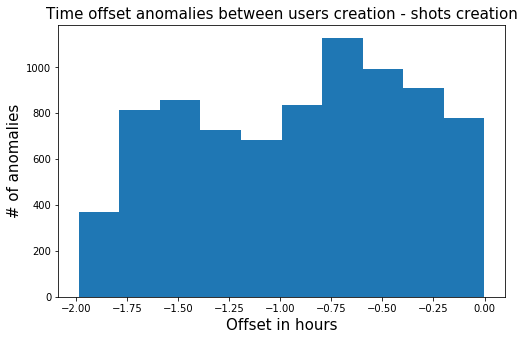

In [25]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(anomalies_user_shot.timediff_hours)
ax.set_title("Time offset anomalies between users creation - shots creation", fontsize = 15)
ax.set_xlabel("Offset in hours", fontsize = 15)
ax.set_ylabel("# of anomalies", fontsize = 15);

#### Solution

We decide to set as new creation date (*created_at*) of these anomalous users in the 'users' table, the date corresponding to the relative oldest shot (-1 minute).

In [26]:
# New data creation.
fix_anomalies = anomalies_user_shot.groupby("id_author_shot", as_index = False)["created_at_shot"].min()
fix_anomalies.created_at_shot = fix_anomalies.created_at_shot - pd.Timedelta("1 minute")
fix_anomalies.rename({"created_at_shot": "created_at_user", "id_author_shot": "id"}, axis = 1, inplace = True)
fix_anomalies.head()

,id,created_at_user
0,5,2009-07-31 13:29:35
1,7,2009-08-05 20:56:15
2,14,2009-08-07 11:17:21
3,16,2009-08-07 14:58:52
4,17,2009-08-07 17:26:52
...,...,...
4826,2046398,2017-12-22 20:12:52
4827,2047727,2017-12-24 09:58:45
4828,2047852,2017-12-24 13:20:51
4829,2054386,2017-12-29 14:32:59


In [27]:
# Save the dataframe into the sql database.
fix_anomalies.to_sql("anomalies_user_shot", conn, index = False, dtype = {"id": "INT", "created_at_user": "TIMESTAMP"})

# Fix anomalies.
c.execute("""CREATE UNIQUE INDEX idx_anomalies_user_shot ON anomalies_user_shot (id)""")
c.execute("""UPDATE users SET (created_at) = (SELECT anomalies_user_shot.created_at_user FROM anomalies_user_shot WHERE anomalies_user_shot.id = users.id)
                WHERE EXISTS (SELECT * FROM anomalies_user_shot WHERE anomalies_user_shot.id = users.id)""")

c.execute("""DROP TABLE anomalies_user_shot""")

conn.commit()

In [28]:
# Reload 'users' table.
users = pd.read_sql("SELECT id, created_at FROM users", conn)

### creation team_username - creation shot

Compute the time offset between the publication of the shots and the creation of the corresponding teams for which the shot was published.

In [29]:
# Compute the time offset between the pubblication of the shots and the creation of the corresponding teams for which the shot was published.
team_shot = pd.merge(shots[["id_team_username", "id_author_shot", "created_at", "updated_at", "shot_id"]], users[["id", "created_at"]], 
                     left_on = "id_team_username", right_on = "id", suffixes = ("_shot", "_team_username"), how = "left").drop("id", axis = 1)
team_shot.rename({"updated_at": "updated_at_shot"}, axis = 1, inplace = True)

team_shot["timediff"] = team_shot.created_at_shot - team_shot.created_at_team_username

In [30]:
# Anomalies.
anomalies_team_shot = team_shot[team_shot.timediff < pd.Timedelta(0)]
# Get the number of hours of our timedelta.
anomalies_team_shot["timediff_hours"] = anomalies_team_shot["timediff"] / pd.Timedelta("1 hour")
anomalies_team_shot.sort_values(by = "timediff_hours", inplace = True)
anomalies_team_shot

,id_team_username,id_author_shot,created_at_shot,updated_at_shot,shot_id,created_at_team_username,timediff,timediff_hours
1323781,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889
1323780,1735178.0,3013,2010-07-15 10:29:26,2017-10-16 19:50:47,35459,2017-05-18 18:47:30,-2500 days +15:41:56,-59984.301111
1134170,1953864.0,1097,2011-04-16 20:05:37,2017-10-21 21:31:16,149882,2017-10-21 20:42:41,-2381 days +23:22:56,-57120.617778
1134147,1953864.0,1097,2011-07-29 17:44:52,2017-10-21 21:26:20,225257,2017-10-21 20:42:41,-2277 days +21:02:11,-54626.963611
1134146,1953864.0,1097,2011-08-01 18:24:10,2017-10-21 21:25:59,226983,2017-10-21 20:42:41,-2274 days +21:41:29,-54554.308611
...,...,...,...,...,...,...,...,...
280352,1045498.0,908898,2016-01-06 18:04:45,2016-07-30 22:34:04,2441366,2016-01-06 18:07:14,-1 days +23:57:31,-0.041389
802882,993261.0,985776,2015-11-07 18:36:03,2016-12-24 23:32:08,2339631,2015-11-07 18:38:28,-1 days +23:57:35,-0.040278
2317272,688973.0,5993,2014-11-08 09:04:11,2016-08-20 10:53:25,1799934,2014-11-08 09:05:58,-1 days +23:58:13,-0.029722
2110911,1064301.0,1064293,2016-01-25 19:37:52,2016-01-26 17:57:17,2481023,2016-01-25 19:39:29,-1 days +23:58:23,-0.026944


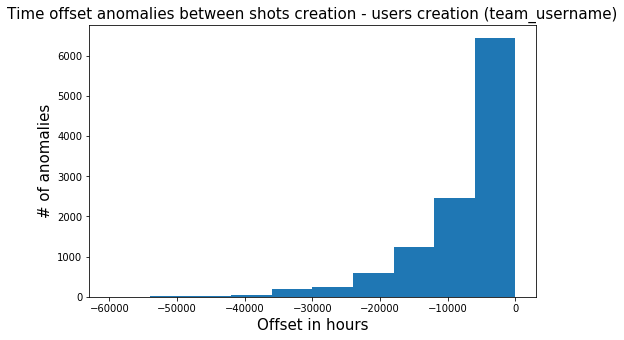

In [31]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(anomalies_team_shot.timediff_hours)
ax.set_title("Time offset anomalies between shots creation - users creation (team_username)", fontsize = 15)
ax.set_xlabel("Offset in hours", fontsize = 15)
ax.set_ylabel("# of anomalies", fontsize = 15);

In [33]:
# We notice how the updating of the shot is always after the creation of the corresponding team.
# Maybe if a user pass to work for a team and decide to update an old shot, it becomes property of the team. 
timediff = anomalies_team_shot.updated_at_shot - anomalies_team_shot.created_at_team_username
timediff

1323781   151 days 01:02:53
1323780   151 days 01:03:17
1134170     0 days 00:48:35
1134147     0 days 00:43:39
1134146     0 days 00:43:18
                 ...       
280352    206 days 04:26:50
802882    413 days 04:53:40
2317272   651 days 01:47:27
2110911     0 days 22:17:48
1632989   287 days 00:13:32
Length: 11271, dtype: timedelta64[ns]

In [34]:
# Number of anomalies.
sum(timediff < pd.Timedelta(0))

0

In [36]:
# Let's analyze the amount of comments received by these shots after the creation of the corresponding team.
comments_received = pd.merge(anomalies_team_shot, comments, on = "shot_id").rename({"created_at": "created_at_comment"}, axis = 1)
comments_received.head()

,id_team_username,id_author_shot,created_at_shot,updated_at_shot,shot_id,created_at_team_username,timediff,timediff_hours,comment_id,created_at_comment,id_author_comment
0,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,87380,2010-07-15 11:16:14,1366
1,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,87400,2010-07-15 11:47:57,1157
2,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,87408,2010-07-15 11:57:36,1000
3,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,87530,2010-07-15 14:15:57,3013
4,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,90302,2010-07-20 15:03:23,526


In [37]:
comments_received["in_team"] = comments_received.created_at_comment >= comments_received.created_at_team_username

comments_received.in_team.value_counts(normalize = True)
# False: comments received before the team creation.
# True: comments received after the team creation.

False    0.916506
True     0.083494
Name: in_team, dtype: float64

In [38]:
# Let's analyze the amount of likes received by these shots after the creation of the corresponding team.
likes_received = pd.merge(anomalies_team_shot, likes[["created_at", "shot_id", "like_id"]], on = "shot_id").rename({"created_at": "created_at_like"}, axis = 1)
likes_received.head()

,id_team_username,id_author_shot,created_at_shot,updated_at_shot,shot_id,created_at_team_username,timediff,timediff_hours,created_at_like,like_id
0,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,2014-06-26 15:37:25,29253801
1,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,2011-12-31 10:56:36,5046409
2,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,2011-10-03 08:55:08,3562915
3,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,2011-05-28 19:35:49,1946657
4,1735178.0,3013,2010-07-15 10:13:58,2017-10-16 19:50:23,35455,2017-05-18 18:47:30,-2500 days +15:26:28,-59984.558889,2010-07-30 19:53:22,172763


In [39]:
likes_received["in_team"] = likes_received.created_at_like >= likes_received.created_at_team_username

likes_received.in_team.value_counts(normalize = True)
# False: comments received before the team creation.
# True: comments received after the team creation.

False    0.775133
True     0.224867
Name: in_team, dtype: float64

#### Solution

Due to these analysis, we decide to rearrange these shots as published by only the single authors and not for the teams.

In [40]:
shots_chunk = pd.read_sql("SELECT * FROM shots", conn, chunksize = 10)
chunck = next(shots_chunk)
shots_chunk.close()

columns_team = chunck.filter(regex = "team").columns
columns_team

Index(['team_username', 'team_id', 'team_name', 'team_bio', 'team_location',
       'team_buckets_count', 'team_comments_received_count',
       'team_followers_count', 'team_followings_count', 'team_likes_count',
       'team_likes_received_count', 'team_projects_count',
       'team_rebounds_received_count', 'team_shots_count',
       'team_can_upload_shot', 'team_type', 'team_pro', 'team_created_at',
       'team_updated_at', 'team_members_count', 'id_team_username'],
      dtype='object')

In [41]:
update_values = "UPDATE shots SET " + "=NULL,".join(columns_team) + "=NULL" + " WHERE shot_id = ?"
update_values

'UPDATE shots SET team_username=NULL,team_id=NULL,team_name=NULL,team_bio=NULL,team_location=NULL,team_buckets_count=NULL,team_comments_received_count=NULL,team_followers_count=NULL,team_followings_count=NULL,team_likes_count=NULL,team_likes_received_count=NULL,team_projects_count=NULL,team_rebounds_received_count=NULL,team_shots_count=NULL,team_can_upload_shot=NULL,team_type=NULL,team_pro=NULL,team_created_at=NULL,team_updated_at=NULL,team_members_count=NULL,id_team_username=NULL WHERE shot_id = ?'

In [42]:
for index, row in anomalies_team_shot.iterrows():
    c.execute(update_values, (row.shot_id,))
    conn.commit()

In [43]:
# Reload 'shots' table.
shots = pd.read_sql("SELECT shot_id, created_at, updated_at, id_author_shot, id_team_username, team_created_at FROM shots", conn)

# Users -- Followers

### creation social connection - creation 'destination' user

Compute the time offset between the creation of the social connection and the creation of the corresponding 'destination' user. 

We expect to have always the social connection after the creation of the corresponding 'destination' user.

In [44]:
# Compute the time offset between the creation of the connection and the creation of the corresponding 'destination' user.
user_destination = pd.merge(followers[["id_destination", "created_at", "id_source"]], users[["id", "created_at"]], left_on = "id_destination", 
                            right_on = "id", suffixes = ("_connection", "_destination"), how = "left").drop("id", axis = 1)

user_destination["timediff"] = user_destination.created_at_connection - user_destination.created_at_destination

In [45]:
# Anomalies.
anomalies_destination = user_destination[user_destination.timediff < pd.Timedelta(0)]
# Get the number of hours of our timedelta.
anomalies_destination["timediff_hours"] = anomalies_destination["timediff"] / pd.Timedelta("1 hour")
anomalies_destination.sort_values(by = "timediff_hours", inplace = True)
anomalies_destination

,id_destination,created_at_connection,id_source,created_at_destination,timediff,timediff_hours
17501932,123536,2012-03-29 15:44:03,17811,2012-03-29 17:44:03,-1 days +22:00:00,-2.000000
7063335,1788739,2017-06-23 11:00:02,14497,2017-06-23 13:00:02,-1 days +22:00:00,-2.000000
17565907,346173,2013-06-06 12:24:38,133141,2013-06-06 14:24:38,-1 days +22:00:00,-2.000000
17565902,351651,2013-06-15 18:28:39,133141,2013-06-15 20:28:39,-1 days +22:00:00,-2.000000
7063593,36180,2011-05-20 12:22:16,948,2011-05-20 14:22:16,-1 days +22:00:00,-2.000000
...,...,...,...,...,...,...
15268043,1101613,2016-03-03 05:33:25,9975,2016-03-03 05:33:26,-1 days +23:59:59,-0.000278
2820423,21285,2011-03-04 09:57:54,13353,2011-03-04 09:57:55,-1 days +23:59:59,-0.000278
15311064,1577,2010-03-22 18:18:26,389,2010-03-22 18:18:27,-1 days +23:59:59,-0.000278
20788165,330350,2013-05-08 21:20:44,22,2013-05-08 21:20:45,-1 days +23:59:59,-0.000278


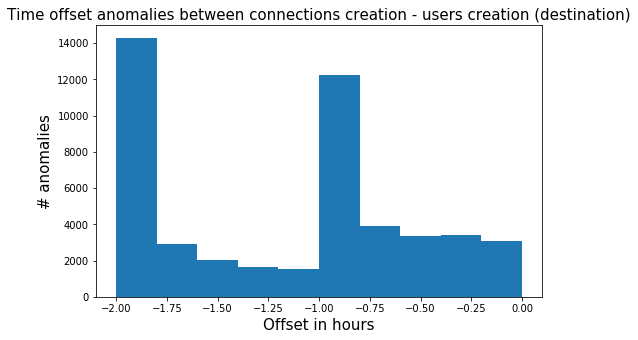

In [46]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(anomalies_destination.timediff_hours)
ax.set_title("Time offset anomalies between connections creation - users creation (destination)", fontsize = 15)
ax.set_xlabel("Offset in hours", fontsize = 15)
ax.set_ylabel("# anomalies", fontsize = 15);

#### Solution

We decide to set as new creation date (*created_at*) of these anomalous 'destination' users in the 'users' table, the date corresponding to the relative oldest connection (-1 minute).

In [47]:
# Oldest connection for the 'destination' users anomalies.
fix_anomalies = anomalies_destination.groupby("id_destination", as_index = False)["created_at_connection"].min()
fix_anomalies.rename({"created_at_connection": "created_at_user", "id_destination": "id"}, axis = 1, inplace = True)
fix_anomalies.created_at_user = fix_anomalies.created_at_user - pd.Timedelta("1 minute")
fix_anomalies.head()

,id,created_at_user
0,1,2009-07-07 23:50:22
1,4,2009-07-21 21:31:24
2,5,2009-07-31 13:23:18
3,6,2009-08-04 19:06:24
4,7,2009-08-05 20:35:03


In [48]:
# Save the dataframe into the sql database.
fix_anomalies.to_sql("anomalies_destination", conn, index = False, dtype = {"id": "INT", "created_at_user": "TIMESTAMP"})

# Fix anomalies.
c.execute("""CREATE UNIQUE INDEX idx_anomalies_destination ON anomalies_destination (id)""")
c.execute("""UPDATE users SET (created_at) = (SELECT anomalies_destination.created_at_user FROM anomalies_destination WHERE anomalies_destination.id = users.id)
                WHERE EXISTS (SELECT * FROM anomalies_destination WHERE anomalies_destination.id = users.id)""")

c.execute("""DROP TABLE anomalies_destination""")

conn.commit()

In [49]:
# Reload 'users' table.
users = pd.read_sql("SELECT id, created_at FROM users", conn)

### creation social connection -  creation 'source' user

Compute the time offset between the creation of the social connection and the creation of the corresponding 'source' user.

We expect to have always the social connection after the creation of the corresponding 'source' user.

In [50]:
# Compute the time offset between the creation of the links and the creation of the corresponding 'source' user.
user_source = pd.merge(followers[["id_destination", "created_at", "id_source"]], users[["id", "created_at"]], 
                       left_on = "id_source", right_on = "id", suffixes = ("_connection", "_source"), 
                       how = "left").drop("id", axis = 1)

user_source["timediff"] = user_source.created_at_connection - user_source.created_at_source

In [51]:
anomalies_source = user_source[user_source.timediff < pd.Timedelta(0)]
# Get the number of hours of our timedelta.
anomalies_source["timediff_hours"] = anomalies_source["timediff"] / pd.Timedelta("1 hour")
anomalies_source.sort_values(by = "timediff_hours", inplace = True)
anomalies_source

,id_destination,created_at_connection,id_source,created_at_source,timediff,timediff_hours
21678139,1,2009-07-07 23:51:22,49,2009-09-03 07:20:00,-58 days +16:31:22,-1375.477222
11472555,4,2009-07-21 21:32:24,51,2009-09-16 11:24:15,-57 days +10:08:09,-1357.864167
21678141,1,2009-07-07 23:51:22,48,2009-08-30 22:07:33,-54 days +01:43:49,-1294.269722
21678140,1,2009-07-07 23:51:22,47,2009-08-27 22:39:01,-51 days +01:12:21,-1222.794167
21678138,1,2009-07-07 23:51:22,46,2009-08-25 11:11:15,-49 days +12:40:07,-1163.331389
...,...,...,...,...,...,...
854115,327,2011-11-10 07:43:55,74607,2011-11-10 07:43:56,-1 days +23:59:59,-0.000278
19484408,38195,2016-12-17 03:52:16,1518140,2016-12-17 03:52:17,-1 days +23:59:59,-0.000278
2952862,21317,2013-11-27 03:18:05,451023,2013-11-27 03:18:06,-1 days +23:59:59,-0.000278
11247332,986,2011-01-18 10:03:56,11685,2011-01-18 10:03:57,-1 days +23:59:59,-0.000278


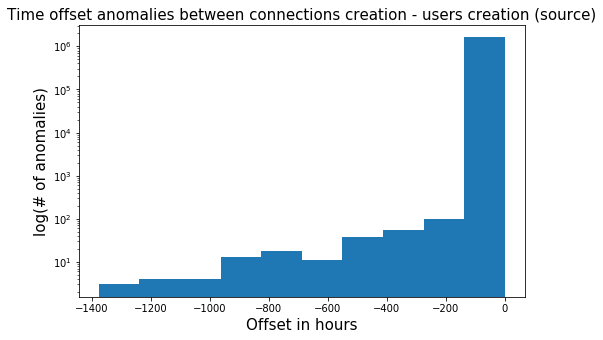

In [52]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(anomalies_source.timediff_hours)
ax.set_yscale("log")
ax.set_title("Time offset anomalies between connections creation - users creation (source)", fontsize = 15)
ax.set_xlabel("Offset in hours", fontsize = 15)
ax.set_ylabel("log(# of anomalies)", fontsize = 15);

#### Solution

We decide to set as new creation date (created_at) of these anomalous 'source' users in the 'users' table, the date corresponding to the relative oldest connection (-1 minute).

In [53]:
# Oldest connection for the 'source' users anomalies.
fix_anomalies = anomalies_source.groupby("id_source", as_index = False)["created_at_connection"].min()
fix_anomalies.rename({"created_at_connection": "created_at_user", "id_source": "id"}, axis = 1, inplace = True)
fix_anomalies.created_at_user = fix_anomalies.created_at_user - pd.Timedelta("1 minute")
fix_anomalies.head()

,id,created_at_user
0,4,2009-07-07 23:50:22
1,5,2009-07-07 23:50:22
2,6,2009-07-07 23:50:22
3,7,2009-07-07 23:50:22
4,8,2009-07-07 23:50:22


In [54]:
# Save the dataframe into the sql database.
fix_anomalies.to_sql("anomalies_source", conn, index = False, dtype = {"id": "INT", "created_at_user": "TIMESTAMP"})

# Fix anomalies.
c.execute("""CREATE UNIQUE INDEX idx_anomalies_source ON anomalies_source (id)""")
c.execute("""UPDATE users SET (created_at) = (SELECT anomalies_source.created_at_user FROM anomalies_source WHERE anomalies_source.id = users.id)
                WHERE EXISTS (SELECT * FROM anomalies_source WHERE anomalies_source.id = users.id)""")

c.execute("""DROP TABLE anomalies_source""")

conn.commit()

In [55]:
# Reload 'users' table.
users = pd.read_sql("SELECT id, created_at FROM users", conn)

## Users -- Likes

### creation author like - creation like

Compute the time offset between the creation of the likes and the creation of the corresponding authors.

We expect to have always the likes after the creation of the corresponding authors.

In [56]:
# Compute the time offset between the creation of the likes and the creation of the corresponding authors.
user_like = pd.merge(likes[["id_author_like", "created_at"]], users[["id", "created_at"]], left_on = "id_author_like", right_on = "id", 
                     suffixes = ("_like", "_author"), how = "left").drop("id", axis = 1)

user_like["timediff"] = user_like.created_at_like - user_like.created_at_author

In [57]:
anomalies_user_like = user_like[user_like.timediff < pd.Timedelta(0)]
# Get the number of hours of our timedelta.
anomalies_user_like["timediff_hours"] = anomalies_user_like["timediff"] / pd.Timedelta("1 hour")
anomalies_user_like.sort_values(by = "timediff_hours", inplace = True)
anomalies_user_like

,id_author_like,created_at_like,created_at_author,timediff,timediff_hours
43181761,814629,2014-04-16 09:53:23,2015-04-09 13:59:55,-359 days +19:53:28,-8596.108889
79555443,814629,2014-09-10 20:20:42,2015-04-09 13:59:55,-211 days +06:20:47,-5057.653611
69632103,814629,2014-09-10 20:22:58,2015-04-09 13:59:55,-211 days +06:23:03,-5057.615833
64202106,814629,2014-09-10 20:23:29,2015-04-09 13:59:55,-211 days +06:23:34,-5057.607222
68102811,814629,2014-09-10 20:23:57,2015-04-09 13:59:55,-211 days +06:24:02,-5057.599444
...,...,...,...,...,...
42458432,2010306,2017-11-29 11:00:13,2017-11-29 11:00:14,-1 days +23:59:59,-0.000278
45017837,176964,2012-07-15 19:53:59,2012-07-15 19:54:00,-1 days +23:59:59,-0.000278
6614809,1018906,2015-12-07 12:30:53,2015-12-07 12:30:54,-1 days +23:59:59,-0.000278
82947620,1176839,2016-05-18 11:10:21,2016-05-18 11:10:22,-1 days +23:59:59,-0.000278


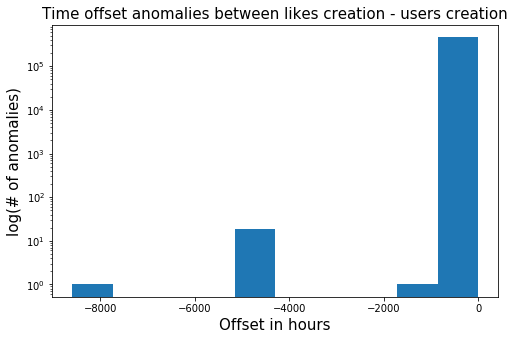

In [58]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(anomalies_user_like.timediff_hours)
ax.set_yscale("log")
ax.set_title("Time offset anomalies between likes creation - users creation", fontsize = 15)
ax.set_xlabel("Offset in hours", fontsize = 15)
ax.set_ylabel("log(# of anomalies)", fontsize = 15);

#### Solution

We decide to set as new creation date (created_at) of these anomalous users in the 'users' table, the date corresponding to the relative oldest like (-1 minute).

In [59]:
# Oldest like for the users anomalies.
fix_anomalies = anomalies_user_like.groupby("id_author_like", as_index = False)["created_at_like"].min()
fix_anomalies.rename({"created_at_like": "created_at_user", "id_author_like": "id"}, axis = 1, inplace = True)
fix_anomalies.created_at_user = fix_anomalies.created_at_user - pd.Timedelta("1 minute")
fix_anomalies.head()

,id,created_at_user
0,191,2009-11-18 19:45:36
1,731,2010-01-21 17:51:47
2,924,2010-02-18 16:11:05
3,1263,2010-03-18 16:40:13
4,1458,2010-03-19 15:07:52


In [60]:
# Save the dataframe into the sql database.
fix_anomalies.to_sql("anomalies_user_like", conn, index = False, dtype = {"id": "INT", "created_at_user": "TIMESTAMP"})

# Fix anomalies.
c.execute("""CREATE UNIQUE INDEX idx_anomalies_user_like ON anomalies_user_like (id)""")
c.execute("""UPDATE users SET (created_at) = (SELECT anomalies_user_like.created_at_user FROM anomalies_user_like WHERE anomalies_user_like.id = users.id)
                WHERE EXISTS (SELECT * FROM anomalies_user_like WHERE anomalies_user_like.id = users.id)""")

c.execute("""DROP TABLE anomalies_user_like""")

conn.commit()

In [61]:
# Reload 'users' table.
users = pd.read_sql("SELECT id, created_at FROM users", conn)

## Users -- Comments

### creation author comment - creation comment

Compute the time offset between the creation of the comments and the creation of the corresponding authors.

We expect to have alwyas the comments published after the creation of the corresponding authors.

In [62]:
# Compute the time offset between the creation of the comments and the creation of the corresponding authors.
user_comment = pd.merge(comments[["id_author_comment", "created_at", "comment_id"]], users[["id", "created_at"]], left_on = "id_author_comment", right_on = "id", 
                        suffixes = ("_comment", "_author"), how = "left").drop("id", axis = 1)

user_comment["timediff"] = user_comment.created_at_comment - user_comment.created_at_author

In [63]:
anomalies_user_comment = user_comment[user_comment.timediff < pd.Timedelta(0)]
# Get the number of hours of our timedelta.
anomalies_user_comment["timediff_hours"] = anomalies_user_comment["timediff"] / pd.Timedelta("1 hour")
anomalies_user_comment.sort_values(by = "timediff_hours", inplace = True)
anomalies_user_comment

,id_author_comment,created_at_comment,comment_id,created_at_author,timediff,timediff_hours
4600293,725412,2012-12-12 03:22:31,2033268,2014-12-28 16:27:10,-747 days +10:55:21,-17917.077500
4627020,725412,2013-01-17 20:24:43,2140554,2014-12-28 16:27:10,-710 days +03:57:33,-17036.040833
4523426,725412,2013-01-17 20:25:19,2140558,2014-12-28 16:27:10,-710 days +03:58:09,-17036.030833
4738405,725412,2013-01-23 10:01:19,2158106,2014-12-28 16:27:10,-705 days +17:34:09,-16902.430833
4343044,1925260,2015-12-10 17:07:14,4883037,2017-10-01 18:38:58,-662 days +22:28:16,-15865.528889
...,...,...,...,...,...,...
1632009,22354,2011-03-09 08:34:50,333307,2011-03-09 08:35:57,-1 days +23:58:53,-0.018611
2113630,2806,2010-06-07 11:18:55,61686,2010-06-07 11:19:51,-1 days +23:59:04,-0.015556
3362942,1844763,2017-08-02 06:07:45,6431725,2017-08-02 06:08:39,-1 days +23:59:06,-0.015000
2520899,256,2009-12-15 23:19:19,4536,2009-12-15 23:19:46,-1 days +23:59:33,-0.007500


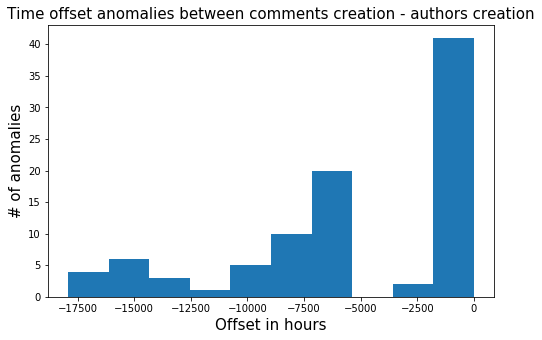

In [64]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(anomalies_user_comment.timediff_hours)
ax.set_title("Time offset anomalies between comments creation - authors creation", fontsize = 15)
ax.set_xlabel("Offset in hours", fontsize = 15)
ax.set_ylabel("# of anomalies", fontsize = 15);

#### Solution

We decide to set as new creation date (created_at) of these anomalous users in the 'users' table, the date corresponding to the relative oldest comment (-1 minute).

In [65]:
# Oldest comment for the users anomalies.
fix_anomalies = anomalies_user_comment.groupby("id_author_comment", as_index = False)["created_at_comment"].min()
fix_anomalies.rename({"created_at_comment": "created_at_user", "id_author_comment": "id"}, axis = 1, inplace = True)
fix_anomalies.created_at_user = fix_anomalies.created_at_user - pd.Timedelta("1 minute")
fix_anomalies.head()

,id,created_at_user
0,175,2009-11-15 11:53:47
1,256,2009-12-15 23:18:19
2,731,2010-01-21 17:46:15
3,889,2010-02-09 15:37:29
4,2164,2010-06-02 12:20:00


In [66]:
# Save the dataframe into the sql database.
fix_anomalies.to_sql("anomalies_user_comment", conn, index = False, dtype = {"id": "INT", "created_at_user": "TIMESTAMP"})

# Fix anomalies.
c.execute("""CREATE UNIQUE INDEX idx_anomalies_user_comment ON anomalies_user_comment (id)""")
c.execute("""UPDATE users SET (created_at) = (SELECT anomalies_user_comment.created_at_user FROM anomalies_user_comment WHERE anomalies_user_comment.id = users.id)
                WHERE EXISTS (SELECT * FROM anomalies_user_comment WHERE anomalies_user_comment.id = users.id)""")

c.execute("""DROP TABLE anomalies_user_comment""")

conn.commit()

In [67]:
# Reload 'users' table.
users = pd.read_sql("SELECT id, created_at FROM users", conn)

In [68]:
c.execute("VACUUM");

In [69]:
conn.close()